Formula 1 is the highest level of racing in the world, with drivers from various different countries competing at a very high level. Recently, it has become much more popular in the United States, as races have began to take place in Miami, Austin, and Las Vegas. Generally speaking, the structure of a Formula 1 race is broken down into two sections, the qualifying and the actual race. In the qualifying, drivers race on the track alone, and whoever has the quickest time is placed first in the grid at the beginning of the race, which is typically thought of as a signifigant advantage. Additionally, Formula 1 is not only diverse in the nations represented, but also ages. As it does not require as much athletic ability as other sports, we see much older drivers competing. As such, we are interested in running a regression to see how much the grid position and age play a factor in predicting the position result. We beleive that these two topics are especially relavent as we contend that being placed near the beginning of the grid has a signifigant effect on the finishing position, and that older age results in a lower finishing position due to decreased reflexes. 

For this model, we are interested in data from the drivers, races, and results datasets. The drivers dataset contains 855 observations, where each row represents a driver that has competed in some F1 competiton. We are interested in their date of birth, which we will convert to age later in the project. The races dataset includes 1080 observations, which are each unique races that have occured over the history of F1. We are interested in the year column, as that will help us calculate the age of the driver when the race took place. Lastly, we are interested in the results dataset. In this dataset, each row represents a specific race by a specific driver. In total, the dataset contains 25660 observations. In this dataset, we are most interested in the grid and positionOrder columns. The grid column gives the number for the order that each driver is lined up at in the beginning of the race based on qualification speed. For example, the first driver would have a grid number of 1, and the worst driver in qualification would have the same number as the amount of racers. The positionOrder column simply gives the number for the order of finishing in the race. All three of these datasets contain information from 1950 to 2022. 

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


In [83]:
drivers = pd.read_csv('/Users/nielsarmbruster/Downloads/archive/drivers.csv')

In [84]:
races = pd.read_csv('/Users/nielsarmbruster/Downloads/archive/races.csv')
results = pd.read_csv('/Users/nielsarmbruster/Downloads/archive/results.csv')
merged_data = pd.merge(results,drivers[["driverId","dob"]], on='driverId', how='left')
merged_data2 = pd.merge(merged_data,races[['raceId','date']], on='raceId', how='left')
merged_data2["dob"] = pd.to_datetime(merged_data2["dob"])
merged_data2["date"] = pd.to_datetime(merged_data2["date"])

merged_data2.dtypes

born = merged_data2["dob"]
date_at_race = merged_data2["date"]

for a in range (0, len(merged_data2)):
     merged_data2.loc[a, "Age"] = date_at_race[a].year - born[a].year - ((date_at_race[a].month, 
                                           date_at_race[a].day) < (born[a].month, 
                                                         born[a].day))

In the code above, we employed two different merges. The first merge connects the results table to the driverId and dob columns for the drivers table, which essentially just adds the dob column as they are merged on driverId. This merge is joined on the left. 

For the second merge, we merge our previous merge again to the races dataset in this instance. We only include the raceId and the date columns from the races data as we simply want to add the date column to our previous merged data. Thus, we merge on raceId on the left. 

With all of this data in one dataframe, we are able to calculate the age of each driver at each race by using a for loop and converting the dob and date columns to datetime format. From this, we generate a new column with the age of each driver in the merged dataframe. 

In [85]:
reg = smf.ols('positionOrder ~ grid + Age', data=merged_data2).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:          positionOrder   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     316.7
Date:                Tue, 21 Nov 2023   Prob (F-statistic):          1.30e-136
Time:                        01:17:34   Log-Likelihood:                -88547.
No. Observations:               25660   AIC:                         1.771e+05
Df Residuals:                   25657   BIC:                         1.771e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.2095      0.286     42.694      0.0

From these regression results, we can see that for each position higher a driver is in the grid, they can expect to finish .1615 positions higher, which means that a higher grid position results in a higher final position. Also, we see that for every year older a driver is, we expect that they will have a position decrease by .0380, meaning that age is negatively correlated with position order, and that older drivers fare better in F1.

In reading the table results in the P>|t| column, we see that the values for both variables are 0.000, which informs us that both variables are statistically signifigant at all confidence levels. Thus, we can reject the null hypotheses that grid positon and age have no effect on position order and instead conclude that grid position has a positive effect on position order, and that age has a negative effect. 



Text(0.5, 1.0, 'Age of F1 Drivers')

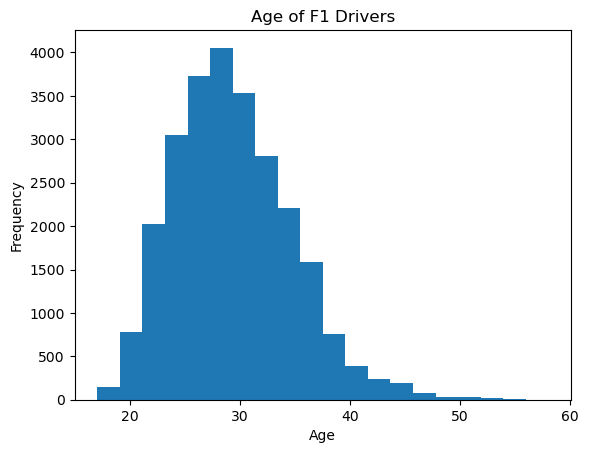

In [86]:
plt.hist(merged_data2["Age"], bins=20);
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age of F1 Drivers")

Here, we can see that the age of drivers in F1 is fairly symmetric and approximately normal, with an average of around 28 years old. This is particularly interesting because our regression suggests that age is negatively correlated with position order, so we might expect a left tail as drivers do not join the competition until they are older for fear of lack of experience. Yet, we do not see this, which may suggest that young drivers are overconfident in their abilities. 

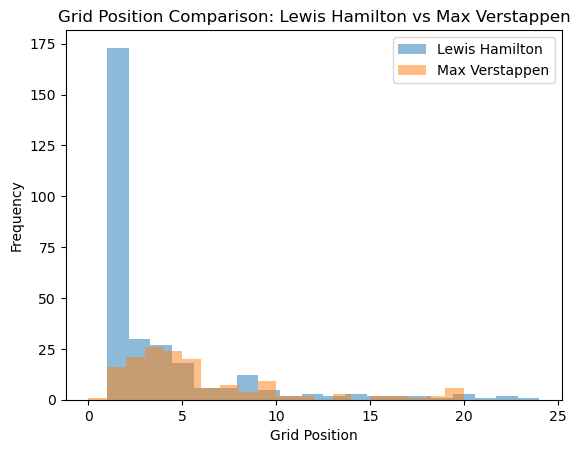

In [87]:
hamilton_data = merged_data2[merged_data2["driverId"] == 1]
verstappen_data = merged_data2[merged_data2["driverId"] == 830]

plt.hist(hamilton_data["grid"], bins=20, alpha=0.5, label="Lewis Hamilton")
plt.hist(verstappen_data["grid"], bins=20, alpha=0.5, label="Max Verstappen")
plt.xlabel("Grid Position")
plt.ylabel("Frequency")
plt.title("Grid Position Comparison: Lewis Hamilton vs Max Verstappen")
plt.legend()
plt.show()

In this plot, it is interesting to compare two of F1's most recent successful drivers, Lewis Hamilton and Max Verstappen. Over the past five years, they have been roughly equally succesful, so it is interesting to compare their distribution of grid positions. From the graph, we can see that Lewis Hamilton has qualified in the first grid position a much higher percentage of the time than Max Verstappen. The most logical explanation for this is that Lewis Hamilton is a better driver than Max Verstappen without other drivers on the track, and Verstappen is better than Hamilton when there are other drivers, given that they have both been equally succesful recently. 